The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 注意力池化：Nadaraya-Watson 内核回归

:label:`sec_nadaraya-waston`

在知道了 :numref:`fig_qkv` 框架下注意力机制的主要组成部分。重述要点，查询（自主提示）和键（非自主提示）之间的交互产生了 * 注意力池化 *。注意力池化有选择性地聚合了值（感官输入）以产生输出。在本节中，我们将更详细地介绍注意力池化，以便从高层次上了解注意力机制在实践中的运作方式。具体来说，1964 年提出的 Nadaraya-Watson 核回归模型是一个简单而完整的示例，用于演示具有注意机制的机器学习。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## 生成数据集

简单起见，考虑回归问题：给定“输入－输出”对 $\{(x_1, y_1), \ldots, (x_n, y_n)\}$ 的数据集，如何学习 $f$ 来预测任何新的输入 $x$ 的输出 $\hat{y} = f(x)$？

根据下面的非线性函数生成一个人工数据集，噪声项为 $\epsilon$：

$$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon,\epsilon\sim\mathcal{N}(0,0.5)$$

其中 $\epsilon$ 服从均值为 0 和标准差为 0.5 的正态分布。同时生成了 50 个训练样本和 50 个测试样本。为了更好地可视化注意力模式，输入的训练样本将进行排序。


In [2]:
n_train = 50  # 训练样本的个数
x_train, _ = torch.sort(torch.rand(n_train) * 5)  # 训练样本的输入

In [3]:
def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本的个数
n_test

50

以下函数绘制所有训练样本（由圆圈表示）、不带噪声项的真实数据生成函数 `f`（标记为 “Truth”）和学习得到的预测函数（标记为 “Pred”）。


In [4]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

## 平均池化

首先，可能是世界上对这个回归问题的 “最愚蠢” 的估算器：使用平均池化来计算所有训练输出的平均值：

$$f(x) = \frac{1}{n}\sum_{i=1}^n y_i,$$
:eqlabel:`eq_avg-pooling`

如下图所示，这个估算器确实不聪明。


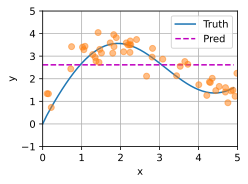

In [5]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

## 非参数的注意力池化

显然，平均池化模型忽略了输入 $x_i$。一个更好的想法由 Nadaraya :cite:`Nadaraya.1964` 和 Waston :cite:`Watson.1964` 提出，根据输入的位置对输出 $y_i$ 进行权衡：

$$f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i,$$
:eqlabel:`eq_nadaraya-waston`

其中 $K$ 是 * 核函数 *。:eqref:`eq_nadaraya-waston` 中的估计器被称为 *Nadaraya-Watson 核回归 *。在这里我们不会深入讨论核的细节。回想一下 :numref:`fig_qkv` 中的注意力机制框架。从注意力的角度来看，我们可以用 * 注意力池化 * 的更一般的形式重写 :eqref:`eq_nadaraya-waston`：

$$f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i,$$
:eqlabel:`eq_attn-pooling`

其中 $x$ 是查询，$(x_i, y_i)$ 是“键－值”对。比较 :eqref:`eq_attn-pooling` 和 :eqref:`eq_avg-pooling`，这里的注意力池化是 $y_i$ 的加权平均值。根据被 $\alpha$ 模型化的查询 $x$ 和键 $x_i$ 之间的交互作用，将 :eqref:`eq_attn-pooling` 中的 * 注意力权重 * $\alpha(x, x_i)$ 分配给相应的值 $y_i$。对于任何查询，模型在所有“键－值”对上的注意力权重都是有效的概率分布：它们是非负数的，总和为一。

为了获得注意力池化的直觉认识，仅需要考虑一个 * 高斯内核 * ，其定义为

$$
K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2}).
$$

将高斯内核插入 :eqref:`eq_attn-pooling` 和 :eqref:`eq_nadaraya-waston` 就会给出

$$\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}$$
:eqlabel:`eq_nadaraya-waston-gaussian`

在 :eqref:`eq_nadaraya-waston-gaussian` 中，通过给键 $x_i$ 对应的值 $y_i$ 分配更多的注意力权重使得与查询 $x$ 越接近的键能够获得更多的注意力。

尤其是 Nadaraya-Watson 核回归是一个非参数模型；因此，:eqref:`eq_nadaraya-waston-gaussian` 就是 * 非参数的注意力池化 * 的示例。在下面，我们将基于这个非参数的注意力池化模型绘制预测。预测的线是平稳的，并且比平均池化产生的线更接近真实数据。


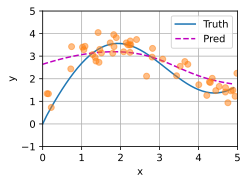

In [6]:
# `X_repeat` 的形状: (`n_test`, `n_train`),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# `x_train` 包含着键。`attention_weights` 的形状：(`n_test`, `n_train`),
# 每一行都包含着要在给定的每个查询的值（`y_train`）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# `y_hat` 的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

现在，让我们来观察注意力的权重。这里测试输入是查询，而训练输入是键。由于两个输入都是排过序的，观察可知“查询－键”对越接近，注意力池化的注意力权重就越高。


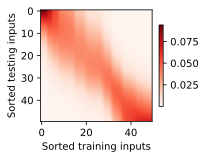

In [7]:
d2l.show_heatmaps(
    attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

## 带参数的注意力池化

非参数的 Nadaraya-Watson 核回归的 * 一致性 * ：如果有足够的数据，此模型会收敛到最佳解决方案。尽管如此，我们还可以轻松地将可学习的参数集成到注意力池化中。

例如，与 :eqref:`eq_nadaraya-waston-gaussian` 略有不同，在下面的查询 $x$ 和键 $x_i$ 之间的距离乘以可学习参数 $w$：

$$\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_i)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}$$
:eqlabel:`eq_nadaraya-waston-gaussian-para`

在本节的剩余部分，我们将通过学习 :eqref:`eq_nadaraya-waston-gaussian-para` 中注意力池化的参数来训练此模型。

### 批量矩阵乘法

:label:`subsec_batch_dot`

为了更有效地计算小批量数据的注意力，我们可以利用深度学习框架提供的批量矩阵乘法应用程序。

假设第一个小批量包含 $n$ 个矩阵 $\mathbf{X}_1,\ldots, \mathbf{X}_n$，形状为 $a\times b$，第二个小批量包含 $n$ 个矩阵 $\mathbf{Y}_1, \ldots, \mathbf{Y}_n$，形状为 $b\times c$。它们的批量矩阵乘法得出 $n$ 个矩阵 $\mathbf{X}_1\mathbf{Y}_1, \ldots, \mathbf{X}_n\mathbf{Y}_n$，形状为 $a\times c$。因此，假定两个张量的形状 $(n,a,b)$ 和 $(n,b,c)$ ，它们的批量矩阵乘法输出的形状为 $(n,a,c)$。


In [8]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

在注意力机制的背景下，我们可以使用小批量矩阵乘法来计算小批量中的值的加权平均值。


In [9]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

### 定义模型

使用小批量矩阵乘法，下面根据 :eqref:`eq_nadaraya-waston-gaussian-para` 中的带参数的注意力池化来定义 Nadaraya-Watson 核回归的带参数版本。


In [10]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # `queries` 和 `attention_weights` 的形状:(查询个数, “键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape(
            (-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # `values` 的形状:(查询个数, “键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

### 训练模型

接下来，将训练数据集转换为键和值用于训练注意力模型。在带参数的注意力池化模型中，任何训练的输入都会从所有的训练样本（除了输入样本自己）中获取“键－值”对，而输入样本自己需要用于预测其输出。


In [11]:
# `X_tile` 的形状: (`n_train`, `n_train`), 每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# `Y_tile` 的形状: (`n_train`, `n_train`), 每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# `keys` 的形状: ('n_train', 'n_train' - 1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape(
    (n_train, -1))
# `values` 的形状: ('n_train', 'n_train' - 1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape(
    (n_train, -1))

训练带参数的注意力池化模型时使用平方损失函数和随机梯度下降。


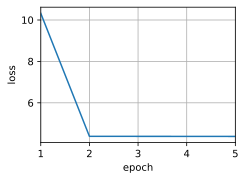

In [12]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    # 注意：L2 Loss = 1/2 * MSE Loss。
    # PyTorch 的 MSE Loss 与 MXNet 的 L2Loss 差一个 2 的因子，因此被减半。
    l = loss(net(x_train, keys, values), y_train) / 2
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

训练带参数的注意力池化模型后，绘制其预测结果。试图使用噪点拟合训练数据集，预测线不如之前绘制的非参数模型的预测线平滑。


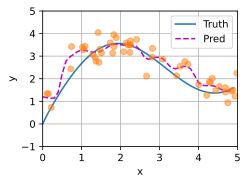

In [13]:
# `keys` 的形状: (`n_test`, `n_train`), 每一行包含着相同的训练输入（例如：相同的键）
keys = x_train.repeat((n_test, 1))
# `value` 的形状: (`n_test`, `n_train`)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

与非参数的注意力池化模型相比，注意力权重较大的区域在可学习的和带参数的设置中变得更加尖锐。


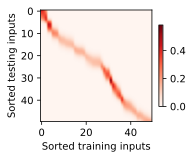

In [14]:
d2l.show_heatmaps(
    net.attention_weights.unsqueeze(0).unsqueeze(0),
    xlabel='Sorted training inputs', ylabel='Sorted testing inputs')

## 小结

* Nadaraya-Watson 核回归是具有注意力机制的机器学习示例。
* Nadaraya-Watson 核回归的注意力池化是训练输出的加权平均值。从注意力的角度来看，根据查询的函数和与值配对的键，将注意力权重分配给值。
* 注意力池化可以是非参数的，也可以是带参数的。

## 练习

1. 增加训练样本的数量。能否更好地学习非参数的 Nadaraya-Watson 核回归？
1. 在带参数的注意力池化的实验中学到的 $w$ 的价值是什么？为什么在可视化注意力权重时，它会使加权区域更加尖锐？
1. 如何将超参数添加到非参数的 Nadaraya-Watson 核回归中以实现更好地预测？
1. 为本节的核回归设计另一个带参数的注意力池化模型。训练这个新模型并可视化其注意力权重。


[Discussions](https://discuss.d2l.ai/t/1599)
